<a href="https://colab.research.google.com/github/danielbrioli/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [11]:
# 1) Write a Bayesian probability function

true_pos = 1      # True pos rate
prior = 1/1000    # Prior
false_pos = .08   # False pos rate

def handmade_bayes(_prior, _false_pos = 0, _true_pos = 1):
  return (_true_pos*_prior) / ((_true_pos*_prior) + (_false_pos*(1 - _prior)))

first = handmade_bayes(prior, false_pos, true_pos)
second = handmade_bayes(first, false_pos, true_pos)
third = handmade_bayes(second, false_pos, true_pos)
fourth = handmade_bayes(third, false_pos, true_pos)

print(first)
print(second)
print(third)
print(fourth)

# After the first test the probability that the driver is drunk is ~1.2%
# After the second test the probability that the driver is drunk is ~13.5%
# Four tests are needed to be 95% certain or greater

0.012357884330202669
0.13525210993291495
0.6615996951348605
0.9606895076105054


  F_LB: 68.67512990398207
F_MEAN: 70.04995836802665
  F_UB: 71.42478683207123
  B_LB: 68.67708849307647
B_MEAN: 70.04995836802665
  B_UB: 71.42282824297683


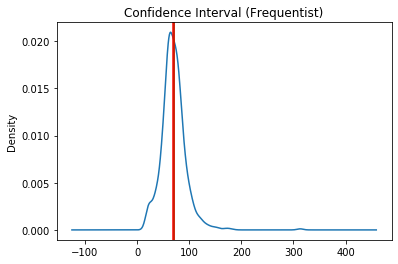

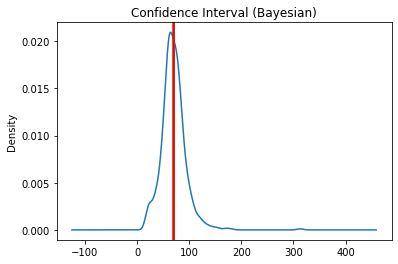

In [60]:
# 2) Explore scipy.stats.bayes_mvs

import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv")
data = data['LotFrontage']
data.dropna(inplace=True)

# Frequentist approach
def f_confidence_interval(num_set, conf=0.95):
  num_set = np.array(num_set)
  mean = np.mean(num_set)
  num_len = len(num_set)
  stderr = np.std(num_set, ddof=1) / np.sqrt(num_len)
  t_stat = stats.t.ppf((1 + conf) / 2.0, num_len - 1)
  margin_of_error = t_stat * stderr
  return mean - margin_of_error, mean, mean + margin_of_error

fci = f_confidence_interval(data)

print("  F_LB: " + str(fci[0]))
print("F_MEAN: " + str(fci[1]))
print("  F_UB: " + str(fci[2]))

bci_mean, bci_var, bci_std = stats.bayes_mvs(data, alpha=0.95)
bci_lb = bci_mean.minmax[0]
bci_ub = bci_mean.minmax[1]

print("  B_LB: " + str(bci_lb))
print("B_MEAN: " + str(bci_mean.statistic))
print("  B_UB: " + str(bci_ub))

data.plot.density()
plt.title("Confidence Interval (Frequentist)")
plt.axvline(x=fci[0], color='red')
plt.axvline(x=fci[1], color='green')
plt.axvline(x=fci[2], color='red');
plt.show()

data.plot.density()
plt.title("Confidence Interval (Bayesian)")
plt.axvline(x=bci_lb, color='red')
plt.axvline(x=bci_mean.statistic, color='green')
plt.axvline(x=bci_ub, color='red');
plt.show()

In [0]:
# 3) Summarize the difference between Bayesian and Frequentist statistics

# In general, frequentist statistics often (or completely) ignores prior 
# assumptions when determining the results of statistical tests. You can
# view it as "philosophically pure" statistics: ignoring prior assumptions,
# you can really only know that the stuff you are measuring is how the state
# of the world actually is.
#
# Bayesian statistics is considered to be how human behavior works, or at least
# approximately. You can take a prior assumption about the state of the world
# and update it based on your sampling within it. Given the prior and also
# given your new sample(s), you can progressively get closer and closer to a 
# more accurate model of what is understood to be the world/global/population
# state.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!